In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =4.06197e-22

nband = 340

ng =9

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 10

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6/

atmosphere_profiles/trp75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

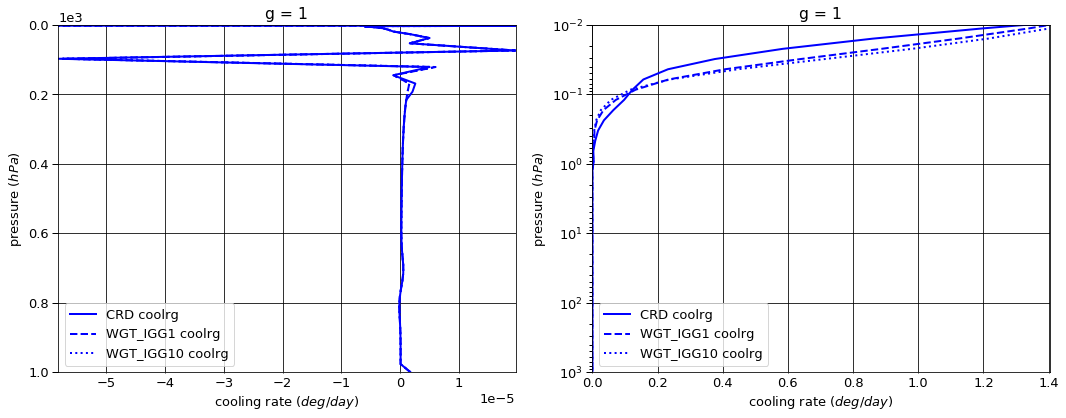

# Figure: cooling rate g-group 2

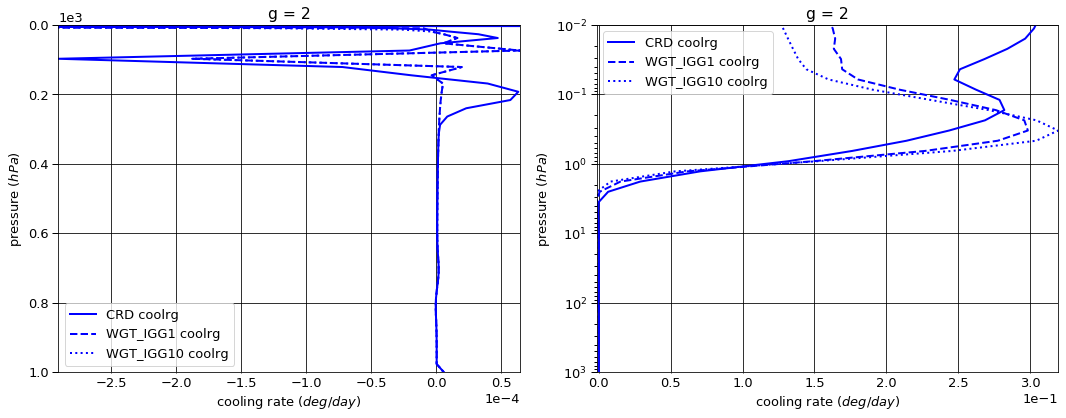

# Figure: cooling rate g-group 3

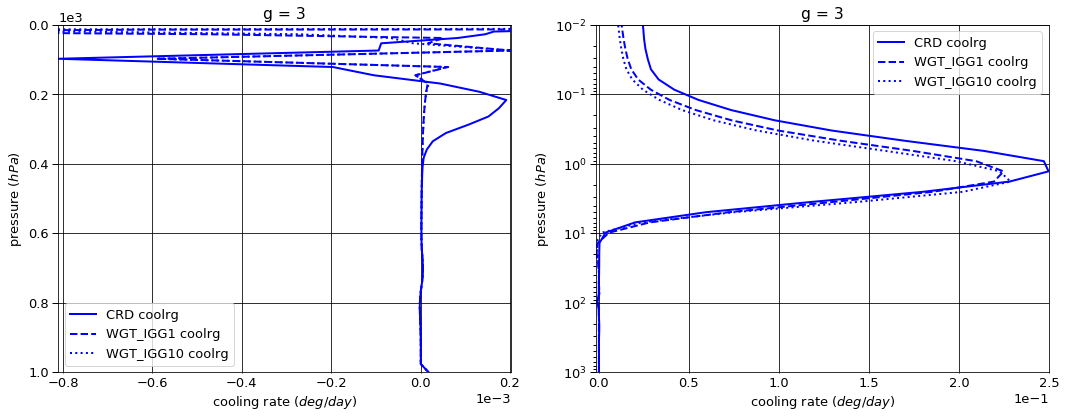

# Figure: cooling rate g-group 4

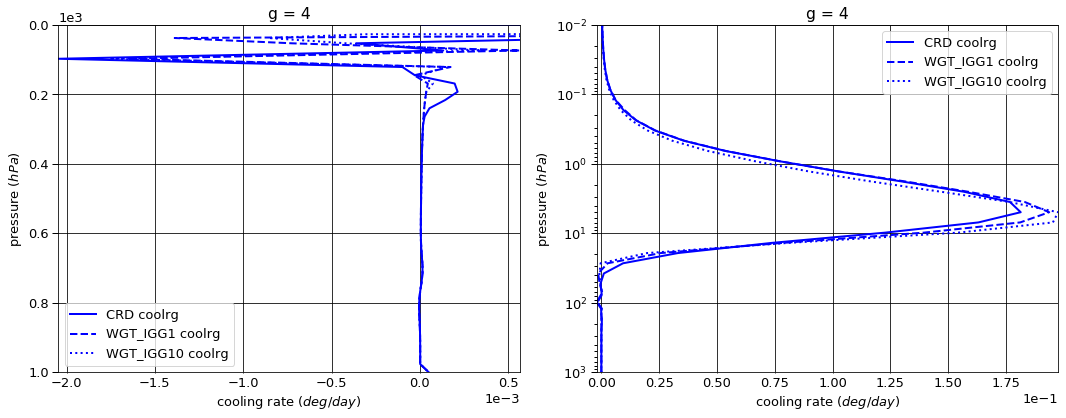

# Figure: cooling rate g-group 5

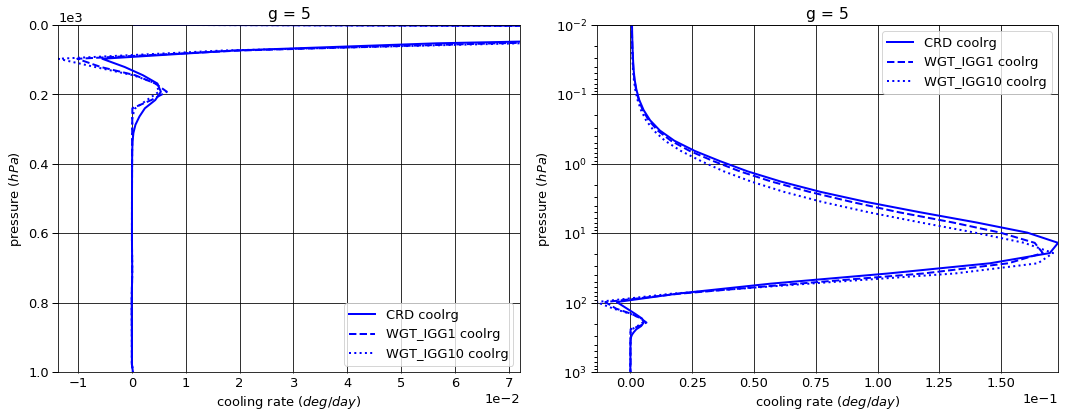

# Figure: cooling rate g-group 6

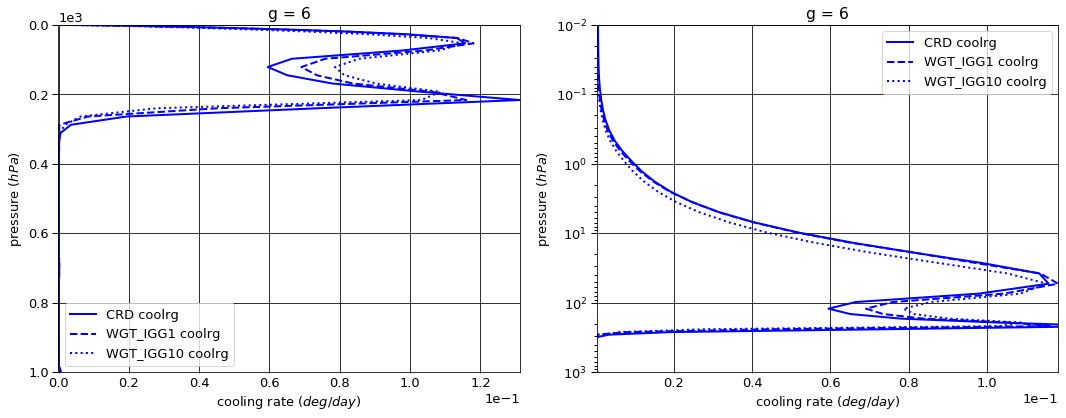

# Figure: cooling rate g-group 7

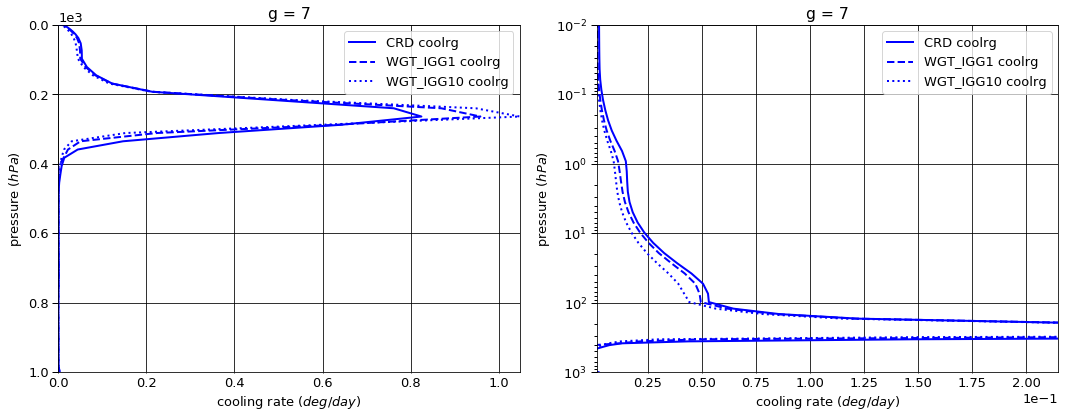

# Figure: cooling rate g-group 8

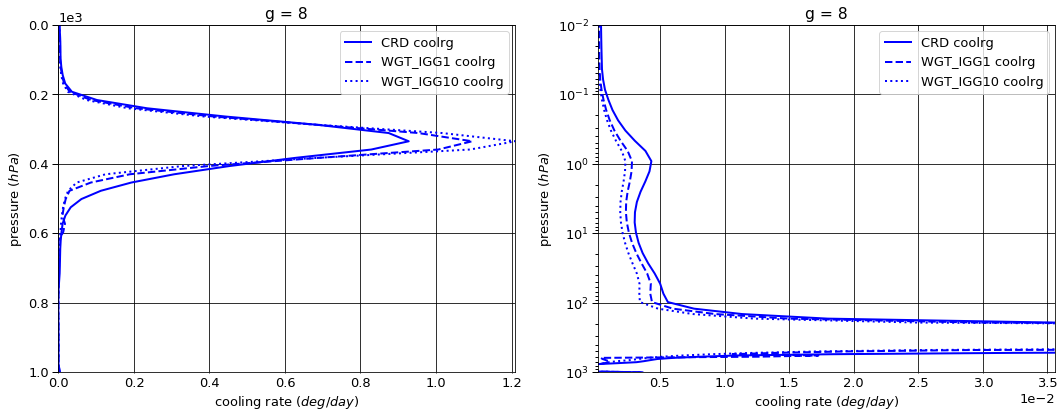

# Figure: cooling rate g-group 9

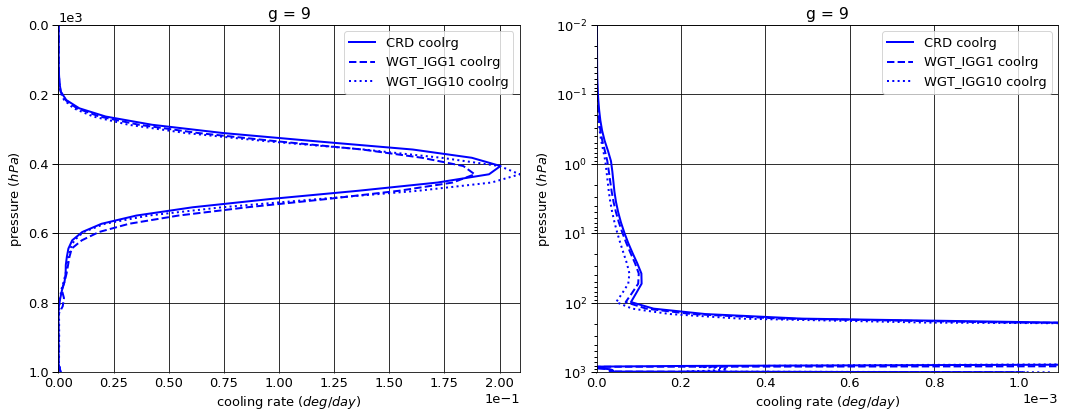

# Figure: cooling rate g-group total

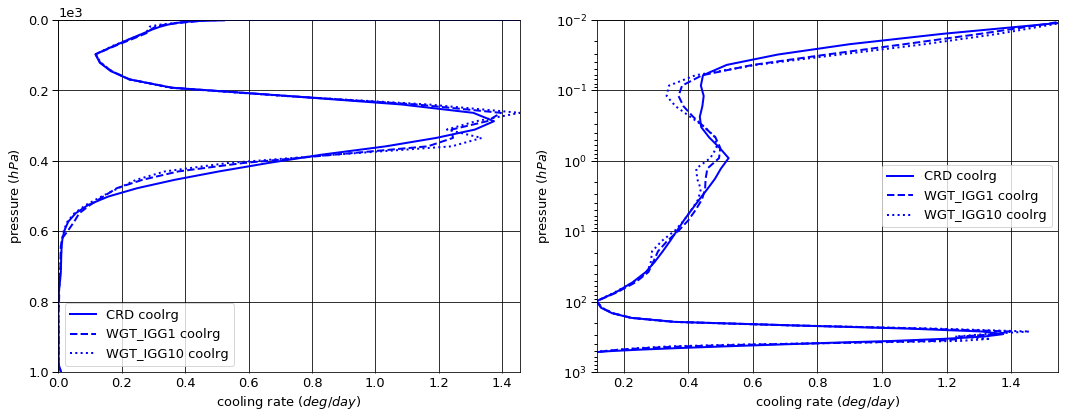

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007676   0.000000  -0.007676
  1013.0   76     -0.013241   0.013236  -0.000005
2 0.0      1      -0.031260   0.000000  -0.031260
  1013.0   76     -0.042959   0.042943  -0.000016
3 0.0      1      -0.103567   0.000000  -0.103567
  1013.0   76     -0.136013   0.135963  -0.000050
4 0.0      1      -0.262420   0.000000  -0.262420
  1013.0   76     -0.383620   0.383480  -0.000140
5 0.0      1      -0.908273   0.000000  -0.908273
  1013.0   76     -1.551960   1.551390  -0.000570
6 0.0      1      -2.639264   0.000000  -2.639264
  1013.0   76     -4.804982   4.803230  -0.001752
7 0.0      1     -11.266546   0.000000 -11.266546
  1013.0   76    -18.119721  18.113046  -0.006676
8 0.0      1     -17.026631   0.000000 -17.026631
  1013.0   76    -25.162992  25.152876  -0.010116
9 0.0      1      -4.429202   0.000000  -4.429202
  1013.0   76     -6.297535   6.294720  -0.002815


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007563   0.000000  -0.007563
  1013.0   76     -0.013241   0.013236  -0.000005
2 0.0      1      -0.031859   0.000000  -0.031859
  1013.0   76     -0.042960   0.042943  -0.000016
3 0.0      1      -0.103427   0.000000  -0.103427
  1013.0   76     -0.136013   0.135963  -0.000050
4 0.0      1      -0.264578   0.000000  -0.264578
  1013.0   76     -0.383620   0.383480  -0.000140
5 0.0      1      -0.903649   0.000000  -0.903649
  1013.0   76     -1.551960   1.551390  -0.000570
6 0.0      1      -2.599046   0.000000  -2.599046
  1013.0   76     -4.804982   4.803230  -0.001752
7 0.0      1     -11.181147   0.000000 -11.181147
  1013.0   76    -18.119721  18.113046  -0.006676
8 0.0      1     -16.901590   0.000000 -16.901590
  1013.0   76    -25.162992  25.152876  -0.010116
9 0.0      1      -4.481534   0.000000  -4.481534
  1013.0   76     -6.297535   6.294739  -0.002796


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007536   0.000000  -0.007536
  1013.0   76     -0.013241   0.013236  -0.000005
2 0.0      1      -0.031940   0.000000  -0.031940
  1013.0   76     -0.042960   0.042943  -0.000016
3 0.0      1      -0.103776   0.000000  -0.103776
  1013.0   76     -0.136013   0.135963  -0.000050
4 0.0      1      -0.264726   0.000000  -0.264726
  1013.0   76     -0.383620   0.383480  -0.000140
5 0.0      1      -0.904334   0.000000  -0.904334
  1013.0   76     -1.551960   1.551390  -0.000570
6 0.0      1      -2.576873   0.000000  -2.576873
  1013.0   76     -4.804982   4.803230  -0.001752
7 0.0      1     -11.183413   0.000000 -11.183413
  1013.0   76    -18.119721  18.113046  -0.006676
8 0.0      1     -16.893272   0.000000 -16.893272
  1013.0   76    -25.162992  25.152876  -0.010116
9 0.0      1      -4.476201   0.000000  -4.476201
  1013.0   76     -6.297535   6.294739  -0.002796


WGT_IGG1 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1      1.126498e-04  0.000000e+00  1.126498e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2 0.0      1     -5.988730e-04  0.000000e+00 -5.988730e-04
  1013.0   76    -6.938894e-18  0.000000e+00  0.000000e+00
3 0.0      1      1.401800e-04  0.000000e+00  1.401800e-04
  1013.0   76     0.000000e+00  0.000000e+00  6.776264e-21
4 0.0      1     -2.157630e-03  0.000000e+00 -2.157630e-03
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5 0.0      1      4.623470e-03  0.000000e+00  4.623470e-03
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
6 0.0      1      4.021850e-02  0.000000e+00  4.021850e-02
  1013.0   76     0.000000e+00  8.881784e-16  0.000000e+00
7 0.0      1      8.539900e-02  0.000000e+00  8.539900e-02
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8 0.0      1      1.250410e-01  0.000000e+00  1.250410e-01
  1013.0   76    -3.552714e-15  3.552714e-15  4.000000e-08
9 0.0      1     -5.233210e-02  0.000000e+00 -5.233210e-02
  1013.0   76     0.000000e+00  1.890000e-05  1.893200e-05


WGT_IGG10 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1      1.394081e-04  0.000000e+00  1.394081e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2 0.0      1     -6.803490e-04  0.000000e+00 -6.803490e-04
  1013.0   76    -6.938894e-18  0.000000e+00  0.000000e+00
3 0.0      1     -2.083300e-04  0.000000e+00 -2.083300e-04
  1013.0   76     0.000000e+00  0.000000e+00  6.776264e-21
4 0.0      1     -2.305460e-03  0.000000e+00 -2.305460e-03
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5 0.0      1      3.939040e-03  0.000000e+00  3.939040e-03
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
6 0.0      1      6.239100e-02  0.000000e+00  6.239100e-02
  1013.0   76     0.000000e+00  8.881784e-16  0.000000e+00
7 0.0      1      8.313300e-02  0.000000e+00  8.313300e-02
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8 0.0      1      1.333590e-01  0.000000e+00  1.333590e-01
  1013.0   76    -3.552714e-15  3.552714e-15  4.000000e-08
9 0.0      1     -4.699890e-02  0.000000e+00 -4.699890e-02
  1013.0   76     0.000000e+00  1.890000e-05  1.893160e-05

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      3.956974
  1001.112500 75     0.000002
2 0.000312    1      0.280452
  1001.112500 75     0.000006
3 0.000312    1      0.019498
  1001.112500 75     0.000018
4 0.000312    1      0.000010
  1001.112500 75     0.000051
5 0.000312    1      0.000413
  1001.112500 75     0.000205
6 0.000312    1      0.000644
  1001.112500 75     0.000631
7 0.000312    1      0.002188
  1001.112500 75     0.002404
8 0.000312    1      0.000341
  1001.112500 75     0.003642
9 0.000312    1      0.000001
  1001.112500 75     0.001014


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      2.154933e+00
  1001.112500 75     1.756907e-06
2 0.000312    1      1.351087e-01
  1001.112500 75     5.795832e-06
3 0.000312    1      9.420571e-03
  1001.112500 75     1.817972e-05
4 0.000312    1      1.011932e-05
  1001.112500 75     5.051737e-05
5 0.000312    1      3.663403e-04
  1001.112500 75     2.051179e-04
6 0.000312    1      3.772811e-04
  1001.112500 75     6.310120e-04
7 0.000312    1      1.533970e-03
  1001.112500 75     2.403988e-03
8 0.000312    1      2.189795e-04
  1001.112500 75     3.641914e-03
9 0.000312    1      7.608845e-07
  1001.112500 75     1.006323e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.815395e+00
  1001.112500 75     1.756907e-06
2 0.000312    1      1.026519e-01
  1001.112500 75     5.795832e-06
3 0.000312    1      7.989633e-03
  1001.112500 75     1.817972e-05
4 0.000312    1      8.877627e-06
  1001.112500 75     5.051737e-05
5 0.000312    1      3.193397e-04
  1001.112500 75     2.051179e-04
6 0.000312    1      3.204955e-04
  1001.112500 75     6.310120e-04
7 0.000312    1      1.234089e-03
  1001.112500 75     2.403988e-03
8 0.000312    1      1.737377e-04
  1001.112500 75     3.641914e-03
9 0.000312    1      5.818550e-07
  1001.112500 75     1.079929e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.802042e+00
  1001.112500 75    -2.117582e-22
2 0.000312    1     -1.453430e-01
  1001.112500 75     8.470329e-22
3 0.000312    1     -1.007712e-02
  1001.112500 75     3.388132e-21
4 0.000312    1      9.391700e-08
  1001.112500 75     0.000000e+00
5 0.000312    1     -4.621823e-05
  1001.112500 75     0.000000e+00
6 0.000312    1     -2.663839e-04
  1001.112500 75     0.000000e+00
7 0.000312    1     -6.541772e-04
  1001.112500 75     0.000000e+00
8 0.000312    1     -1.217124e-04
  1001.112500 75    -1.530000e-08
9 0.000312    1     -4.588075e-07
  1001.112500 75    -7.303900e-06


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.141579e+00
  1001.112500 75    -2.117582e-22
2 0.000312    1     -1.777998e-01
  1001.112500 75     8.470329e-22
3 0.000312    1     -1.150806e-02
  1001.112500 75     3.388132e-21
4 0.000312    1     -1.147772e-06
  1001.112500 75     0.000000e+00
5 0.000312    1     -9.321884e-05
  1001.112500 75     0.000000e+00
6 0.000312    1     -3.231695e-04
  1001.112500 75     0.000000e+00
7 0.000312    1     -9.540582e-04
  1001.112500 75     0.000000e+00
8 0.000312    1     -1.669542e-04
  1001.112500 75    -1.530000e-08
9 0.000312    1     -6.378370e-07
  1001.112500 75     6.630220e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-36.674838,0.000000,-36.674838
1013.0,76,-56.513024,56.490885,-0.022140



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-36.474392,0.000000,-36.474392
1013.0,76,-56.513024,56.490904,-0.022121



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-36.442070,0.000000,-36.442070
1013.0,76,-56.513024,56.490904,-0.022121



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.004462e-01,0.000000,0.200446
1013.0,76,-7.105427e-15,0.000019,0.000019



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.327684e-01,0.000000,0.232768
1013.0,76,-7.105427e-15,0.000019,0.000019


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,4.260520
1001.112500,75,0.007972



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,2.301969
1001.112500,75,0.007965



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,1.928094
1001.112500,75,0.008038



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.958551
1001.112500,75,-0.000007



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.332426
1001.112500,75,0.000066


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000294,0.000239
2,0.000824,0.000771
3,0.002691,0.002451
4,0.008162,0.006948
5,0.032529,0.028072
6,0.103515,0.087107
7,0.374029,0.327326
8,0.383000,0.440913
9,0.094956,0.106174


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.222796e-17
2,5.686282e-18
3,4.476633e-19
4,1.008726e-18
5,8.035412e-20
6,6.290914e-20
7,5.055345e-21
8,4.062448e-22
9,1.792420e-23


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.222796e-17,NaN,0.000294,0.000239,0.000294,0.000239,1.0
2,5.686282e-18,0.078727,0.000824,0.000771,0.001118,0.001011,1.0
3,4.476633e-19,0.078727,0.002691,0.002451,0.003809,0.003461,1.0
4,1.008726e-18,2.253314,0.008162,0.006948,0.011971,0.010409,30.0
5,8.035412e-20,0.079659,0.032529,0.028072,0.044500,0.038480,30.0
6,6.290914e-20,0.782899,0.103515,0.087107,0.148015,0.125587,300.0
7,5.055345e-21,0.080359,0.374029,0.327326,0.522044,0.452913,300.0
8,4.062448e-22,0.080359,0.383000,0.440913,0.905044,0.893826,300.0
9,1.792420e-23,0.044122,0.094956,0.106174,1.000000,1.000000,300.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     3.387406e-16  1.080884e-16   3.133921  1.226689e-02
      2 0.000312     8.630306e-18  3.255763e-18   2.650778  3.368423e-04
      3 0.000312     2.474680e-19  7.154928e-20   3.458708  8.602467e-06
      4 0.000312     3.832821e-23  3.832747e-23   1.000019  2.652024e-09
      5 0.000312     3.740089e-22  2.234604e-22   1.673714  1.858708e-08
      6 0.000312     1.501365e-22  4.829860e-23   3.108507  5.455900e-09
      7 0.000312     1.506583e-22  1.472585e-23  10.230873  6.662311e-09
      8 0.000312     2.158355e-23  1.113302e-24  19.386974  9.268772e-10
      9 0.000312     4.389040e-25  5.159786e-26   8.506246  1.964966e-11
2     1 0.000750     3.393418e-16  1.083492e-16   3.131926  4.951056e-03
      2 0.000750     8.684179e-18  3.271137e-18   2.654789  1.364260e-04
      3 0.000750     2.488691e-19  7.239738e-20   3.437543  3.493219e-06
      4 0.000750     9.120354e-23  9.120026e-23   1.000036  2.541796e-09
      5 0.000750     3.810948e-22  2.292530e-22   1.662333  7.658882e-09
      6 0.000750     1.505742e-22  4.878981e-23   3.086181  2.210806e-09
      7 0.000750     1.511085e-22  1.481542e-23  10.199407  2.692016e-09
      8 0.000750     2.173359e-23  1.121238e-24  19.383574  3.759312e-10
      9 0.000750     4.423515e-25  5.215496e-26   8.481484  7.978480e-12
3     1 0.001052     3.405499e-16  1.087757e-16   3.130754  6.969122e-03
      2 0.001052     8.788447e-18  3.293557e-18   2.668376  1.931578e-04
      3 0.001052     2.510602e-19  7.335619e-20   3.422481  4.950764e-06
      4 0.001052     1.277520e-22  1.277458e-22   1.000049  4.992986e-09
      5 0.001052     3.893851e-22  2.349139e-22   1.657565  1.099279e-08
      6 0.001052     1.510539e-22  4.934401e-23   3.061240  3.121190e-09
      7 0.001052     1.519752e-22  1.493709e-23  10.174354  3.797475e-09
      8 0.001052     2.203582e-23  1.131992e-24  19.466411  5.344563e-10
      9 0.001052     4.489604e-25  5.277669e-26   8.506794  1.135361e-11
4     1 0.001476     3.417714e-16  1.092281e-16   3.128971  9.814384e-03
      2 0.001476     8.896173e-18  3.317980e-18   2.681201  2.736890e-04
      3 0.001476     2.534475e-19  7.448216e-20   3.402794  7.027875e-06
      4 0.001476     1.790455e-22  1.790336e-22   1.000067  9.816911e-09
      5 0.001476     3.991259e-22  2.419042e-22   1.649934  1.585023e-08
      6 0.001476     1.516297e-22  4.999969e-23   3.032612  4.413331e-09
      7 0.001476     1.528813e-22  1.507270e-23  10.142929  5.360230e-09
      8 0.001476     2.234808e-23  1.144006e-24  19.534930  7.603209e-10
      9 0.001476     4.558544e-25  5.351336e-26   8.518516  1.617085e-11
5     1 0.002070     3.429902e-16  1.097095e-16   3.126349  1.381956e-02
      2 0.002070     9.006431e-18  3.344884e-18   2.692599  3.878648e-04
      3 0.002070     2.560627e-19  7.583114e-20   3.376748  9.990163e-06
      4 0.002070     2.510348e-22  2.510117e-22   1.000092  1.930489e-08
      5 0.002070     4.107687e-22  2.507038e-22   1.638462  2.297368e-08
      6 0.002070     1.523330e-22  5.078988e-23   2.999278  6.248846e-09
      7 0.002070     1.538204e-22  1.522597e-23  10.102504  7.566237e-09
      8 0.002070     2.266680e-23  1.157619e-24  19.580532  1.081542e-09
      9 0.002070     4.629877e-25  5.440497e-26   8.510026  2.303761e-11
6     1 0.002904     3.442061e-16  1.102313e-16   3.122582  1.946398e-02
      2 0.002904     9.119835e-18  3.375272e-18   2.701955  5.500376e-04
      3 0.002904     2.589844e-19  7.749174e-20   3.342091  1.423354e-05
      4 0.002904     3.520695e-22  3.520244e-22   1.000128  3.797759e-08
      5 0.002904     4.250427e-22  2.620335e-22   1.622093  3.354357e-08
      6 0.002904     1.532127e-22  5.176702e-23   2.959658  8.867753e-09
      7 0.002904     1.547994e-22  1.540382e-23  10.049412  1.068449e-08
      8 0.002904     2.299259e-23  1.173454e-24  19.593947  1.538891e-09
      9 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.
